* The given a dataset with 15 categories (Reach out to me for the dataset).
* Using **pretrained resnet18, densenet121, vgg19 models** on this dataset, train a **15-class classification model** and **report per-class classification accuracy in terms of precision and recall**.

# **Data Preparation**

**Download and Extract Dataset**

In [1]:
!rm -rf dataset.zip dataset
!wget --no-check-certificate 'ggggghhtydd' -O dataset.zip

In [2]:
!unzip -q dataset.zip

In [2]:
!ls dataset

* **Organize Data into Train and Test Directories**
* **Verify Directory Structure**

In [4]:
import os
import shutil

# Define the path to the original and new datasets
original_dataset_path = 'dataset'
new_dataset_path = 'dataset_new'

# Create new directories for the train and test sets
train_dir = os.path.join(new_dataset_path, 'train')
test_dir = os.path.join(new_dataset_path, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Automatically retrieve the list of class folders
classes = [d for d in os.listdir(original_dataset_path) if os.path.isdir(os.path.join(original_dataset_path, d))]

In [4]:
for class_name in classes:
    # Create class directories in train and test directories
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Get all images in the class folder
    class_folder = os.path.join(original_dataset_path, class_name)
    images = sorted(os.listdir(class_folder))

    # Move images to train or test directories based on their file names
    for image in images:
        image_path = os.path.join(class_folder, image)
        if image.endswith('.jpg') or image.endswith('.png'):  # Check if the file is an image
            image_number = int(image.split('_')[1].split('.')[0])
            if 1 <= image_number <= 40:
                shutil.copy(image_path, os.path.join(train_class_dir, image))
            else:
                shutil.copy(image_path, os.path.join(test_class_dir, image))

# List the created directories for verification
print("Training and testing directories created:")
print(os.listdir(train_dir))
print(os.listdir(test_dir))

In [28]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import precision_score, recall_score, classification_report
import os
import shutil
from random import shuffle, seed

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# **Dataset Handling and Preprocessing**

* Define Custom Dataset Class
* Data Normalization
* Data Loader Definition

In [5]:
# Automatically retrieve the list of class folders
class_names = [d for d in os.listdir(original_dataset_path) if os.path.isdir(os.path.join(original_dataset_path, d))]
print(f"Class names: {class_names}")

class ClassificationDataset(Dataset):
    def __init__(self, folder, class_names):
        self.fpaths = []
        for class_name in class_names:
            self.fpaths += glob(folder + f'/{class_name}/*.jpg')

        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.class_names = class_names
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}
        self.targets = [self.class_to_idx[fpath.split('/')[-2]] for fpath in self.fpaths]  # Store targets as class indices

    def __len__(self):
        return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]

        im = cv2.imread(f)[:, :, ::-1]  # Read the image
        im = cv2.resize(im, (224, 224))  # Resize the image
        im = torch.tensor(im / 255).permute(2, 0, 1)  # Normalize and permute the image dimensions
        im = self.normalize(im)  # Apply normalization

        return im.float(), torch.tensor(target).long()  # Return the image and target as a LongTensor

In [19]:
train_dataset = ClassificationDataset(train_dir, class_names)

In [20]:
train_dataset.__len__()

600

tensor(8)


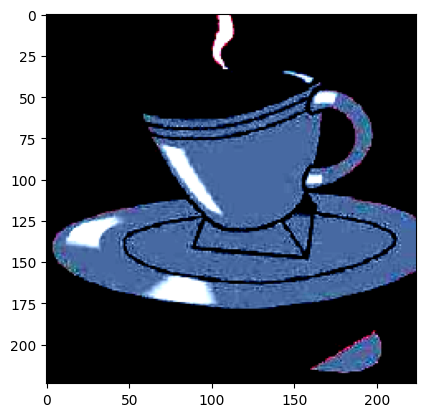

In [21]:
im, label = train_dataset[323]
# permute is to just keep it in the matplotlib way to display it
plt.imshow(im.permute(1,2,0).cpu())
print(label)

# **Model Training Functions**

**Define Training and Testing Functions**

In [22]:
def get_data():
    train = ClassificationDataset(train_dir, class_names)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    test = ClassificationDataset(test_dir, class_names)
    test_dl = DataLoader(test, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, test_dl

In [23]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

**Define Accuracy Calculation Function**

In [24]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    _, preds = torch.max(prediction, 1)  # Get the index of the max log-probability
    is_correct = preds == y
    return is_correct.cpu().numpy().tolist(), preds.cpu().numpy()

# **RESNET18 Model**

**Define Model Architecture**

In [25]:
def get_model():
    model = models.resnet18(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 15))
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

**Train and Evaluate Model**

In [6]:
trn_dl, test_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
test_accuracies = []

**Report Training and Testing Results**

In [11]:
for epoch in range(2):
    train_epoch_losses, train_epoch_accuracies = [], []
    test_epoch_accuracies = []

    all_train_preds, all_train_labels = [], []
    all_test_preds, all_test_labels = [], []

    # Training loop
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)

        is_correct, preds = accuracy(x, y, model)
        all_train_preds.extend(preds)
        all_train_labels.extend(y.cpu().numpy())

    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(np.array(all_train_preds) == np.array(all_train_labels))

    # Test loop
    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        is_correct, preds = accuracy(x, y, model)
        all_test_preds.extend(preds)
        all_test_labels.extend(y.cpu().numpy())

    test_epoch_accuracy = np.mean(np.array(all_test_preds) == np.array(all_test_labels))

    print(f"epoch {epoch + 1}/2, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Test Accuracy: {test_epoch_accuracy}")

    # Calculate precision and recall
    print("Training Precision and Recall")
    print(classification_report(all_train_labels, all_train_preds, target_names=class_names))

    print("Test Precision and Recall")
    print(classification_report(all_test_labels, all_test_preds, target_names=class_names))

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    test_accuracies.append(test_epoch_accuracy)

# **DENSENET121 Model**

**Define Model Architecture**

In [30]:
def get_model():

    model = models.densenet121(pretrained=True)
    # Freeze all parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the classifier (fully connected) layer with a new one
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 15)
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model,loss_fn, optimizer

**Train and Evaluate Model**

In [7]:
trn_dl, test_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
test_accuracies = []

**Report Training and Testing Results**

In [10]:
for epoch in range(2):
    train_epoch_losses, train_epoch_accuracies = [], []
    test_epoch_accuracies = []

    all_train_preds, all_train_labels = [], []
    all_test_preds, all_test_labels = [], []

    # Training loop
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)

        is_correct, preds = accuracy(x, y, model)
        all_train_preds.extend(preds)
        all_train_labels.extend(y.cpu().numpy())

    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(np.array(all_train_preds) == np.array(all_train_labels))

    # Test loop
    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        is_correct, preds = accuracy(x, y, model)
        all_test_preds.extend(preds)
        all_test_labels.extend(y.cpu().numpy())

    test_epoch_accuracy = np.mean(np.array(all_test_preds) == np.array(all_test_labels))

    print(f"epoch {epoch + 1}/2, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Test Accuracy: {test_epoch_accuracy}")

    # Calculate precision and recall
    print("Training Precision and Recall")
    print(classification_report(all_train_labels, all_train_preds, target_names=class_names))

    print("Test Precision and Recall")
    print(classification_report(all_test_labels, all_test_preds, target_names=class_names))

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    test_accuracies.append(test_epoch_accuracy)

# **VGG19 Model**

**Define Model Architecture**

In [33]:
def get_model():
    model = models.vgg19(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    num_ftrs = model.classifier[0].in_features
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, 15)  # Number of classes
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

**Train and Evaluate Model**

In [9]:
trn_dl, test_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
test_accuracies = []

**Report Training and Testing Results**

In [8]:
for epoch in range(2):
    train_epoch_losses, train_epoch_accuracies = [], []
    test_epoch_accuracies = []

    all_train_preds, all_train_labels = [], []
    all_test_preds, all_test_labels = [], []

    # Training loop
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)

        is_correct, preds = accuracy(x, y, model)
        all_train_preds.extend(preds)
        all_train_labels.extend(y.cpu().numpy())

    train_epoch_loss = np.array(train_epoch_losses).mean()
    train_epoch_accuracy = np.mean(np.array(all_train_preds) == np.array(all_train_labels))

    # Test loop
    for ix, batch in enumerate(iter(test_dl)):
        x, y = batch
        is_correct, preds = accuracy(x, y, model)
        all_test_preds.extend(preds)
        all_test_labels.extend(y.cpu().numpy())

    test_epoch_accuracy = np.mean(np.array(all_test_preds) == np.array(all_test_labels))

    print(f"epoch {epoch + 1}/2, Training Loss: {train_epoch_loss}, Training Accuracy: {train_epoch_accuracy}, Test Accuracy: {test_epoch_accuracy}")

    # Calculate precision and recall
    print("Training Precision and Recall")
    print(classification_report(all_train_labels, all_train_preds, target_names=class_names))

    print("Test Precision and Recall")
    print(classification_report(all_test_labels, all_test_preds, target_names=class_names))

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    test_accuracies.append(test_epoch_accuracy)